In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics.pairwise import cosine_similarity



In [2]:
# Set the path to your train, test, and predict directories
train_dir = "/content/drive/MyDrive/fruits/train"
test_dir = "/content/drive/MyDrive/fruits/test"
predict_dir = "/content/drive/MyDrive/fruits/predict"

# Define the number of classes and input shape
num_classes = 10
input_shape = (224, 224, 3)



In [3]:
# Data augmentation and preprocessing
data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Load and augment the train set
train_data = data_generator.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='categorical'
)

# Load and preprocess the test set
test_data = data_generator.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Load and preprocess the predict set
predict_data = data_generator.flow_from_directory(
    predict_dir,
    target_size=input_shape[:2],
    batch_size=1,
    class_mode=None,
    shuffle=False
)

Found 2301 images belonging to 10 classes.
Found 1025 images belonging to 10 classes.
Found 0 images belonging to 0 classes.


In [4]:
# Load the pre-trained ResNet50 model without the top (classification) layer
base_model = ResNet50(weights="imagenet", include_top=False, pooling="avg")

# Freeze the pre-trained layers
base_model.trainable = False

# Create the classification model
model = keras.Sequential([
    base_model,
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_classes, activation='softmax')
])

94765736/94765736 [==============================] - 0s 0us/step


In [5]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(
    train_data,
    epochs=10,
    validation_data=test_data
)


Epoch 1/10
72/72 [==============================] - 833s 11s/step - loss: 0.8933 - accuracy: 0.7136 - val_loss: 1.9132 - val_accuracy: 0.6741
Epoch 2/10
72/72 [==============================] - 52s 726ms/step - loss: 0.3959 - accuracy: 0.8674 - val_loss: 2.0076 - val_accuracy: 0.6878
Epoch 3/10
72/72 [==============================] - 52s 727ms/step - loss: 0.2979 - accuracy: 0.9027 - val_loss: 2.3934 - val_accuracy: 0.6673
Epoch 4/10
72/72 [==============================] - 51s 705ms/step - loss: 0.2645 - accuracy: 0.9192 - val_loss: 2.1720 - val_accuracy: 0.6956
Epoch 5/10
72/72 [==============================] - 52s 724ms/step - loss: 0.2205 - accuracy: 0.9239 - val_loss: 2.3758 - val_accuracy: 0.7122
Epoch 6/10
72/72 [==============================] - 52s 728ms/step - loss: 0.2261 - accuracy: 0.9266 - val_loss: 2.6699 - val_accuracy: 0.6946
Epoch 7/10
72/72 [==============================] - 53s 736ms/step - loss: 0.1719 - accuracy: 0.9509 - val_loss: 2.9014 - val_accuracy: 0.6868


In [12]:
# Function to extract features from an image
def extract_features(image_path):
    img = keras.preprocessing.image.load_img(image_path, target_size=input_shape[:2])
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = base_model.predict(img_array)
    return features.reshape((-1,))

# Function to find similar images based on cosine similarity
def find_similar_image(query_image_path, dataset):
    query_features = extract_features(query_image_path)
    similar_images = []

    for image_path in dataset:
        features = extract_features(image_path)
        similarity = cosine_similarity([query_features], [features])[0][0]
        similar_images.append((image_path, similarity))

    similar_images.sort(key=lambda x: x[1], reverse=True)
    return similar_images




In [13]:
# Example usage
query_image = "/content/drive/MyDrive/fruits/predict/00.jpeg"
dataset = []

# Collect paths of all images in the train and test directories
for class_dir in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_dir)
    for image_file in os.listdir(class_path):
        image_path = os.path.join(class_path, image_file)
        dataset.append(image_path)

for class_dir in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_dir)
    for image_file in os.listdir(class_path):
        image_path = os.path.join(class_path, image_file)
        dataset.append(image_path)

similar_images = find_similar_image(query_image, dataset)

# Print the similar images
print("Similar Images:")
for image_path, similarity in similar_images:
    print(f"Image: {image_path}, Similarity: {similarity}")

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 24ms/step
Similar Images:
Image: /content/drive/MyDrive/fruits/train/cherry/img_2511.jpeg, Similarity: 0.8300124406814575
Image: /content/drive/MyDrive/fruits/train/cherry/img_1841.jpeg, Similarity: 0.8152766227722168
Image: /content/drive/MyDrive/fruits/test/cherry/img_491.jpeg, Similarity: 0.795741617679596
Image: /content/drive/MyDrive/fruits/train/cherry/img_3711.jpeg, Similarity: 0.7945430278778076
Image: /content/drive/MyDrive/fruits/test/cherry/img_241.jpeg, Similarity: 0.7777063250541687
Image: /content/drive/MyDrive/fruits/test/cherry/img_791.jpeg, Similarity: 0.7456004023551941
Image: /content/drive/MyDrive/fruits/test/cherry/img_511.jpeg, Similarity: 0.7404080629348755
Image: /content/drive/MyDrive/fruits/train/cherry/img_3511.jpeg, Similarity: 0.7400786876678467
Image: /content/drive/MyDrive/fruits/test/cherry/img_611.jpeg, Similarity: 0.7358942627906799
Image: /content/drive/MyDriv

In [14]:
import matplotlib.pyplot as plt
# Function to extract features from an image
def extract_features(image_path):
    img = keras.preprocessing.image.load_img(image_path, target_size=input_shape[:2])
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = base_model.predict(img_array)
    return features.reshape((-1,))

# Function to find similar images based on cosine similarity
def find_similar_image(query_image_path, dataset):
    query_features = extract_features(query_image_path)
    similar_images = []

    for image_path in dataset:
        features = extract_features(image_path)
        similarity = cosine_similarity([query_features], [features])[0][0]
        similar_images.append((image_path, similarity))

    similar_images.sort(key=lambda x: x[1], reverse=True)
    return similar_images

1/1 [==============================] - 0s 23ms/step


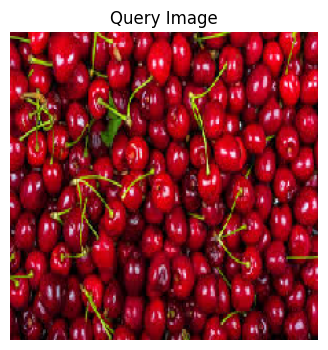

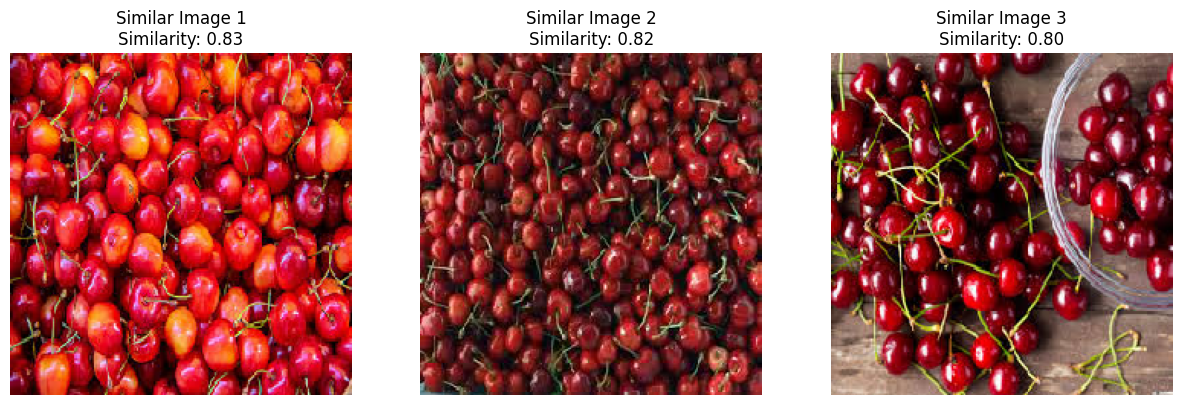

In [16]:
# Example usage
query_image = "/content/drive/MyDrive/fruits/predict/00.jpeg"
dataset = []

# Collect paths of all images in the train and test directories
for class_dir in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_dir)
    for image_file in os.listdir(class_path):
        image_path = os.path.join(class_path, image_file)
        dataset.append(image_path)

for class_dir in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_dir)
    for image_file in os.listdir(class_path):
        image_path = os.path.join(class_path, image_file)
        dataset.append(image_path)

similar_images = find_similar_image(query_image, dataset)

# Show the query image
query_img = keras.preprocessing.image.load_img(query_image, target_size=input_shape[:2])
plt.figure(figsize=(4, 4))
plt.imshow(query_img)
plt.title("Query Image")
plt.axis('off')
plt.show()

# Show the similar images
plt.figure(figsize=(15, 5))
for i in range(3):
    image_path, similarity = similar_images[i]
    similar_img = keras.preprocessing.image.load_img(image_path, target_size=input_shape[:2])
    plt.subplot(1, 3, i+1)
    plt.imshow(similar_img)
    plt.title(f"Similar Image {i+1}\nSimilarity: {similarity:.2f}")
    plt.axis('off')
plt.show()